https://bmcbiol.biomedcentral.com/articles/10.1186/s12915-021-01126-w

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import h5py
from Helper_Functions.accessing_data import h5tree_view
from Helper_Functions.ZBrain_contours import get_vals_from_ref
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

# Making H5 from MatLaB file

In [3]:
infile = "content/allsequences.mat"
outfile = "content/banyuls_data/behaviour_free_swimming.h5"

In [4]:
inf = h5py.File(infile, "r")
outf = h5py.File(outfile, "w")

In [5]:
Xs = [inf[inf["xpos"][0,T]][:] for T in range(0,5)]
Ys = [inf[inf["ypos"][0,T]][:] for T in range(0,5)]
DTHETAs = [inf[inf["dtheta"][0,T]][:] for T in range(0,5)]
DTs = [inf[inf["interboutintervals"][0,T]][:] for T in range(0,5)]

In [6]:
Tempts = [18,22,26,30,33]

In [7]:
bgroup = outf.create_group("behaviour")
bgroup.attrs["framerate"] = inf[inf["framerates"][0,0]][:][0,0]
bgroup.attrs["source"] = "https://bmcbiol.biomedcentral.com/articles/10.1186/s12915-021-01126-w"
for t,T in enumerate(Tempts):
    tgroup = bgroup.create_group(f"{T}")
    tgroup.attrs["temperature"] = f"{T}°C"
    for set, unit in zip(
        ["xpos","ypos","dtheta","interboutintervals","bouttime","displacements"],
        ["mm", "mm", "degree", "s", "s", "mm"]
    ):
        dset = tgroup.create_dataset(set, data=inf[inf[set][0,t]][:])
        dset.attrs["unit"] = unit

In [8]:
h5tree_view(outf)

. content/banyuls_data/behaviour_free_swimming.h5
├── 📁behaviour
│   ├── 🏷️framerate = `24.935128768196524`
│   └── 🏷️source = `https://bmcbiol.biomedcentral.com/articles/10.1186/s12915-021-01126-w`
│   ├── 📁18
│   │   └── 🏷️temperature = `18°C`
│   │   ├── 🔢bouttime ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢displacements ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢dtheta ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `degree`
│   │   ├── 🔢interboutintervals ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢xpos ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢ypos ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `mm`
│   ├── 📁22
│   │   └── 🏷️temperature = `22°C`
│   │   ├── 🔢bouttime ⚙️(1329, 749)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢displacements ⚙️(1329, 748)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢dtheta ⚙️(1329, 748)float64
│   │   │   └── 🏷️unit = `degree`
│   │   ├── 🔢interboutintervals ⚙️(1329, 74

In [9]:
inf.close()
outf.close()

# Get the data

In [3]:
filename = "content/banyuls_data/behaviour_free_swimming.h5"
file = h5py.File(filename, "r")
h5tree_view(file)

. content/banyuls_data/behaviour_free_swimming.h5
├── 📁behaviour
│   ├── 🏷️framerate = `24.935128768196524`
│   └── 🏷️source = `https://bmcbiol.biomedcentral.com/articles/10.1186/s12915-021-01126-w`
│   ├── 📁18
│   │   └── 🏷️temperature = `18°C`
│   │   ├── 🔢bouttime ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢displacements ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢dtheta ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `degree`
│   │   ├── 🔢interboutintervals ⚙️(532, 641)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢xpos ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢ypos ⚙️(532, 642)float64
│   │   │   └── 🏷️unit = `mm`
│   ├── 📁22
│   │   └── 🏷️temperature = `22°C`
│   │   ├── 🔢bouttime ⚙️(1329, 749)float64
│   │   │   └── 🏷️unit = `s`
│   │   ├── 🔢displacements ⚙️(1329, 748)float64
│   │   │   └── 🏷️unit = `mm`
│   │   ├── 🔢dtheta ⚙️(1329, 748)float64
│   │   │   └── 🏷️unit = `degree`
│   │   ├── 🔢interboutintervals ⚙️(1329, 74

# Observe the Data
at 26°C

In [4]:
data = file["/behaviour/26/"]

In [5]:
xs, ys = data["xpos"][:], data["ypos"]
dthetas = data["dtheta"][:]
dts = data["interboutintervals"][:]

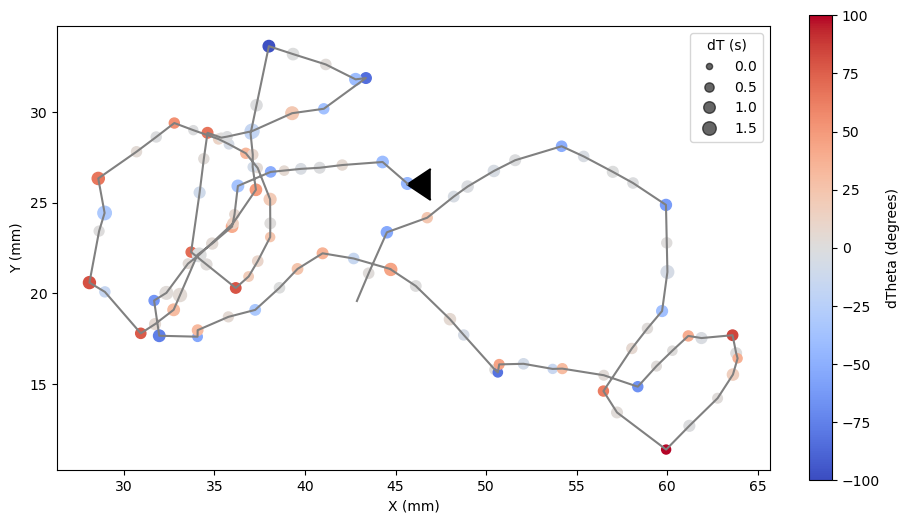

In [17]:
i = 1
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(xs[i], ys[i], color="grey")
h = ax.scatter(
    xs[i], ys[i], c=np.insert(dthetas[i],-1,0), 
    s=np.insert(np.nan_to_num(dts[i]), 0, 0)*50+20,
    cmap="coolwarm", vmin=-100, vmax=+100)
ax.scatter(xs[i,0], ys[i,0], marker=4, s=500, color="k")

fig.colorbar(h, ax=ax, label="dTheta (degrees)", fraction=0.03)
handles, labels = h.legend_elements(prop="sizes", alpha=0.6, num=5, func=lambda x: (x-20)/50)
legend2 = ax.legend(handles, labels, loc="upper right", title="dT (s)")

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_aspect("equal")

# Markov Chaines

In [244]:
def plot_transition_matrix(ax, T, labels=["forward", "left", "right"]):
    h = ax.imshow(T.T, vmin=0, vmax=1, cmap="plasma", origin="lower", aspect="equal")
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            ax.text(i,j, f"{T[i,j]:0.2f}", ha="center", va="center")
    #fig.colorbar(h, ax=ax, label="Transition Probability")
    ax.set_xticks([0,1,2], labels)
    ax.set_yticks([0,1,2], labels)
    ax.set_xlabel("Current step")
    ax.set_ylabel("Next step")
    return h

## Classifying Bouts

In [19]:
from matplotlib.widgets import Slider

In [62]:
%matplotlib inline

0

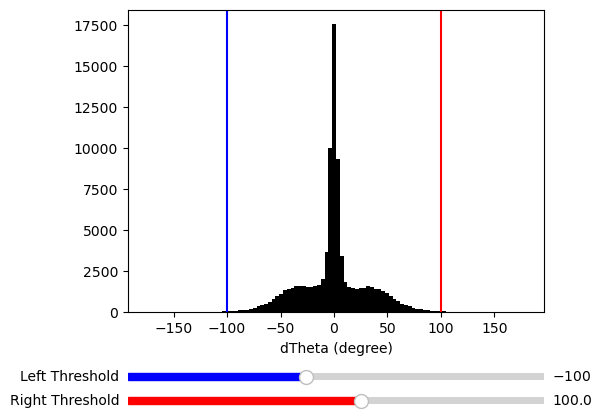

In [63]:
fig, ax = plt.subplots()
ax.hist(dthetas.ravel(), bins=100, color="k");
left_line = ax.axvline(-100, color="blue")
right_line = ax.axvline(+100, color="red")
ax.set_xlabel("dTheta (degree)")

fig.subplots_adjust(left=0.25, bottom=0.25)
# Make a horizontal slider to control the frequency.
axslidL = fig.add_axes([0.25, 0.1, 0.65, 0.03])
left_slider = Slider(
    ax=axslidL,
    label='Left Threshold',
    valmin=np.nanmin(dthetas),
    valmax=0,
    valinit=-100,
    color="blue"
)
axslidR = fig.add_axes([0.25, 0.05, 0.65, 0.03])
right_slider = Slider(
    ax=axslidR,
    label='Right Threshold',
    valmax=np.nanmax(dthetas),
    valmin=0,
    valinit=+100,
    color="red"
)

def update(val):
    left_line.set_xdata([left_slider.val])
    right_line.set_xdata([right_slider.val])
    fig.canvas.draw_idle()

left_slider.on_changed(update)
right_slider.on_changed(update)

In [61]:
left, right = -10, +10

In [173]:
def bout_classifier(dtheta_seqs, left_threshold, right_threshold):
    idx_left = np.where(dtheta_seqs < left_threshold)
    idx_right = np.where(dtheta_seqs > right_threshold)
    bout_seqs = np.zeros_like(dtheta_seqs, dtype=np.int8)
    bout_seqs[idx_left] = 1
    bout_seqs[idx_right] = 2
    bout_seqs[~np.isfinite(dtheta_seqs)] = -1
    return bout_seqs

In [174]:
bouts = bout_classifier(dthetas, left, right)

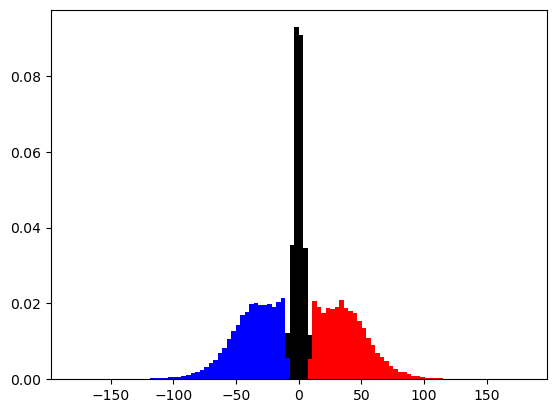

In [175]:
fig, ax = plt.subplots()
#ax.hist(dthetas.ravel(), bins=100, range=[-180, +180],density=True, color="k", histtype="step");
ax.hist(dthetas[bouts==0], bins=100, range=[-180, +180],density=True, color="k");
ax.hist(dthetas[bouts==1], bins=100, range=[-180, +180],density=True, color="blue");
ax.hist(dthetas[bouts==2], bins=100, range=[-180, +180],density=True, color="red");

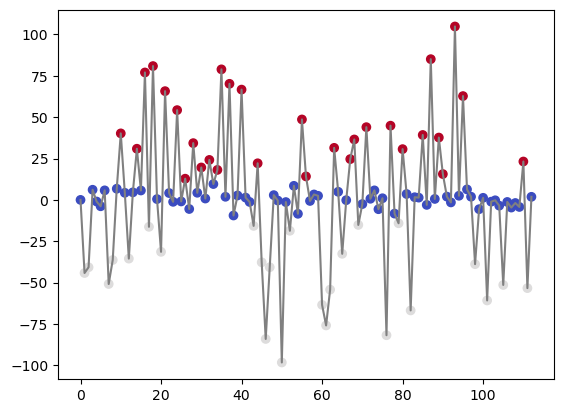

In [176]:
i=1
x = np.arange(len(dthetas[i]))
plt.plot(x, dthetas[i], color="grey")
plt.scatter(x, dthetas[i], c=bouts[i], cmap="coolwarm")

## Bout Probabilities and transitions

In [334]:
def bout_proba(bout_seqs):
    ## WARNING !!!!! there are -1 in the sequences of bouts corresponding to nans in the dtheta sequences
    types, count = np.unique(bout_seqs, return_counts=True)
    if -1 in types:
        n_bout = count[1:]
    else:
        n_bout = count
    n_tot = n_bout.sum()
    p_bout = n_bout/n_tot
    return p_bout

In [178]:
p_bouts = bout_proba(bouts)
p_bouts

array([0.50496375, 0.25018405, 0.2448522 ])

In [179]:
def bout_transition(bout_seqs):
    ## WARNING !!!!! there are -1 in the sequences of bouts corresponding to nans in the dtheta sequences
    T = np.zeros((3,3), dtype=np.int_)
    for s,seq in enumerate(bout_seqs):
        for i in range(len(seq)-1):
            j = i+1
            if seq[j] == -1:
                break
            T[seq[i], seq[j]] += 1
    P = T / T.sum(axis=1)[:,np.newaxis]
    return P

In [180]:
T_bouts = bout_transition(bouts)
T_bouts

array([[0.48783171, 0.25741996, 0.25474833],
       [0.51556403, 0.31468373, 0.16975225],
       [0.52419168, 0.17214826, 0.30366006]])

In [181]:
T_bouts.sum(axis=1)

array([1., 1., 1.])

'\nh = ax.imshow(T_bouts.T, vmin=0, vmax=1, cmap="plasma", origin="lower")\nfor i in range(3):\n    for j in range(3):\n        ax.text(i,j, f"{T_bouts[i,j]:0.2f}", ha="center", va="center")\nfig.colorbar(h, ax=ax, label="Transition Probability")\nax.set_xticks([0,1,2], ["forward", "left", "right"])\nax.set_yticks([0,1,2], ["forward", "left", "right"])\nax.set_xlabel("Current step")\nax.set_ylabel("Next step")\n'

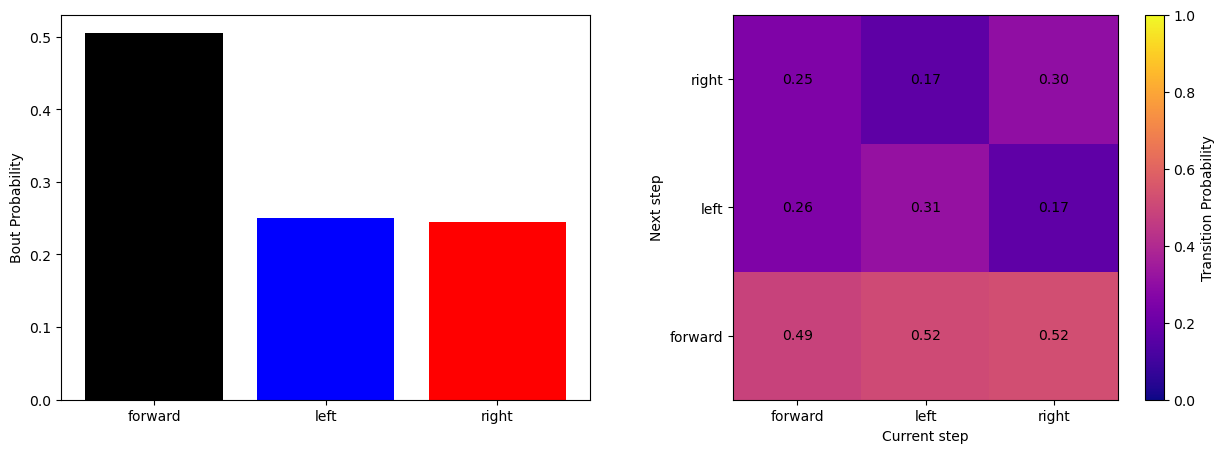

In [245]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

ax = axs[0]
ax.bar([0,1,2], p_bouts, color=["k", "blue", "red"])
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_ylabel("Bout Probability")


ax = axs[1]
h = plot_transition_matrix(ax, T_bouts)
fig.colorbar(h, ax=ax, label="Transition Probability")
"""
h = ax.imshow(T_bouts.T, vmin=0, vmax=1, cmap="plasma", origin="lower")
for i in range(3):
    for j in range(3):
        ax.text(i,j, f"{T_bouts[i,j]:0.2f}", ha="center", va="center")
fig.colorbar(h, ax=ax, label="Transition Probability")
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_yticks([0,1,2], ["forward", "left", "right"])
ax.set_xlabel("Current step")
ax.set_ylabel("Next step")
"""

## Comparing Different temperatures

In [183]:
Temperatures = [18,22,26,30,33]

In [184]:
p_alltemp = np.empty((len(Temperatures), 3))
T_alltemp = np.empty((len(Temperatures), 3, 3))
for t,T in enumerate(Temperatures):
    dthetas = file[f"/behaviour/{T}/dtheta"][:]
    bouts = bout_classifier(dthetas, left, right)
    p_alltemp[t] = bout_proba(bouts)
    T_alltemp[t] = bout_transition(bouts)

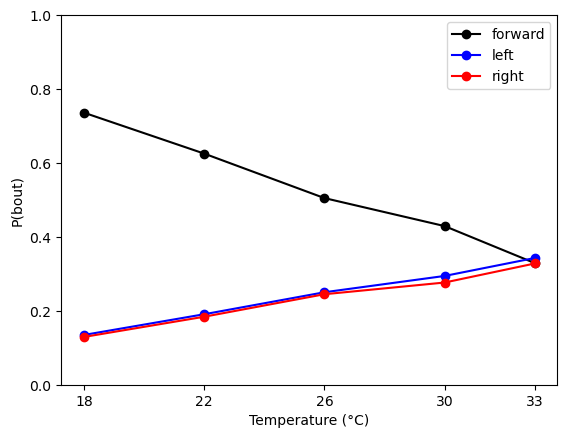

In [199]:
fig, ax = plt.subplots()
ax.plot(Temperatures, p_alltemp[:,0], "-o", color="k", label="forward")
ax.plot(Temperatures, p_alltemp[:,1], "-o", color="blue", label="left")
ax.plot(Temperatures, p_alltemp[:,2], "-o", color="red", label="right")
ax.set_ylim(0,1)
ax.set_xticks(Temperatures)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("P(bout)")
ax.legend()

In [201]:
1-T_alltemp[:,0,0]

array([0.22946298, 0.37372857, 0.51216829, 0.58580954, 0.67177033])

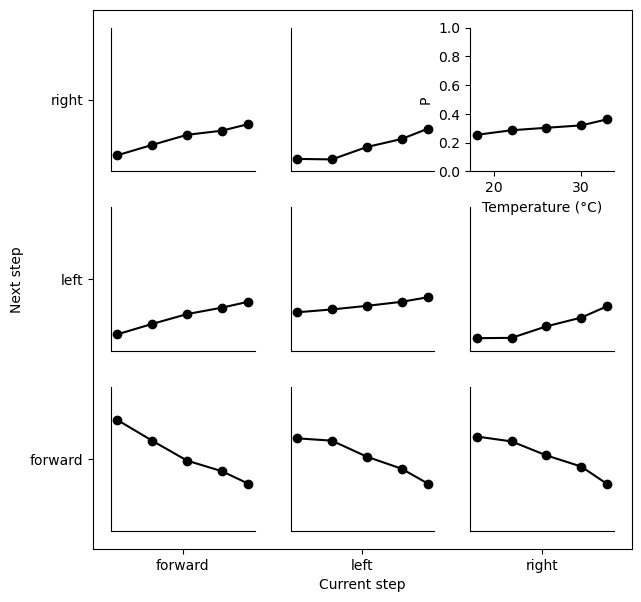

In [229]:
fig, ax = plt.subplots(figsize=(7,7))
#h = ax.imshow(T_bouts.T, vmin=0, vmax=1, cmap="plasma", origin="lower")
for i in range(3):
    for j in range(3):
        axin = ax.inset_axes([i-0.4, j-0.4, 0.8, 0.8], transform=ax.transData)
        if (i,j) != (2,2):
            axin.set_xticks([])
            axin.set_yticks([])
        else:
            axin.set_xlabel("Temperature (°C)")
            axin.set_ylabel("P")
        axin.spines['right'].set_visible(False)
        axin.spines['top'].set_visible(False)
        axin.set_ylim(0,1)
        axin.plot(Temperatures, T_alltemp[:,i,j], "-o",color="k")
#        ax.text(i,j, f"{T_bouts[i,j]:0.2f}", ha="center", va="center")
        
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_yticks([0,1,2], ["forward", "left", "right"])
ax.set_xlabel("Current step")
ax.set_ylabel("Next step")
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.5,2.5)
ax.set_aspect("equal")

## Stationary Distriution

In [259]:
T_power = np.linalg.matrix_power(T_bouts,30)

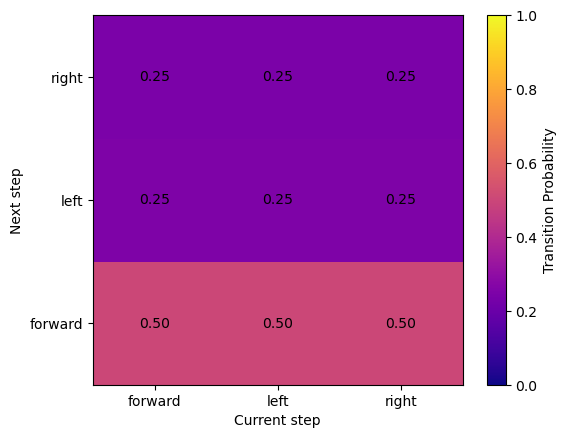

In [260]:
fig, ax = plt.subplots()
h = plot_transition_matrix(ax, T_power)
fig.colorbar(h, ax=ax, label="Transition Probability")

In [264]:
p_bouts

array([0.50496375, 0.25018405, 0.2448522 ])

In [278]:
p_bouts@T_bouts - p_bouts

array([-0.00129104,  0.00068343,  0.00060761])

In [280]:
eigenvals, eigenvects = np.linalg.eig(T_bouts.T)

In [281]:
close_to_1_idx = np.isclose(eigenvals,1)
target_eigenvect = eigenvects[:,close_to_1_idx]
target_eigenvect = target_eigenvect[:,0]

In [282]:
stationary_distrib = target_eigenvect / sum(target_eigenvect) 
stationary_distrib

array([0.50371241, 0.25085664, 0.24543095])

In [283]:
stationary_distrib@T_bouts

array([0.50371241, 0.25085664, 0.24543095])

has the data reached the stationary distribution ?

## Generate a sequence of bouts

In [310]:
def rand_state_from_proba(pbouts, n=None):
    return np.random.choice(np.arange(len(pbouts)), p=pbouts, size=n)

In [320]:
_, count = np.unique(rand_state_from_proba(p_bouts, n=100000), return_counts=True)
count/count.sum()

array([0.50563, 0.24914, 0.24523])

In [323]:
def generate_sequence(N, p, T):
    seq = np.empty(N, dtype=np.int_)
    start = rand_state_from_proba(p)
    seq[0] = start
    for i in range(1,N):
        seq[i] = rand_from_proba(T[seq[i-1]])
    return seq

In [350]:
sequence = generate_sequence(10000,p_bouts, T_bouts)

Text(0.5, 1.0, 'Transition Matrix')

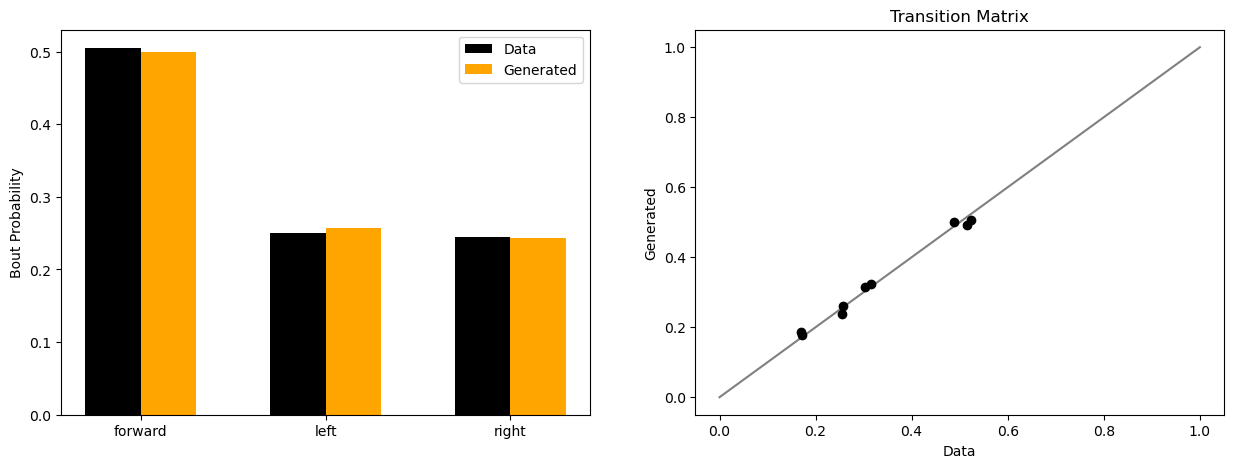

In [363]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

ax = axs[0]
width = 0.3
x = np.arange(3)
ax.bar(x-width/2, p_bouts, width, label="Data", color="k")
ax.bar(x+width/2, bout_proba(sequence), width, label="Generated", color="orange")
ax.legend()
ax.set_xticks([0,1,2], ["forward", "left", "right"])
ax.set_ylabel("Bout Probability")

ax = axs[1]
ax.plot([0,1], [0,1], color="grey", zorder=0)
ax.scatter(T_bouts, bout_transition([sequence]), color="k")
ax.set_xlabel("Data")
ax.set_ylabel("Generated")
ax.set_title("Transition Matrix")

In [364]:
sequence = generate_sequence(100,p_bouts, T_bouts)

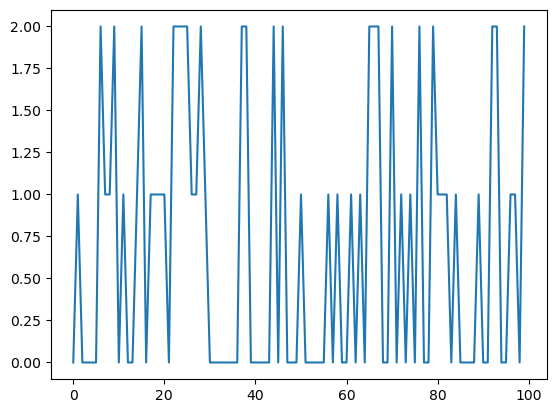

In [366]:
plt.plot(sequence)

# Gaussian Mixture

In [377]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

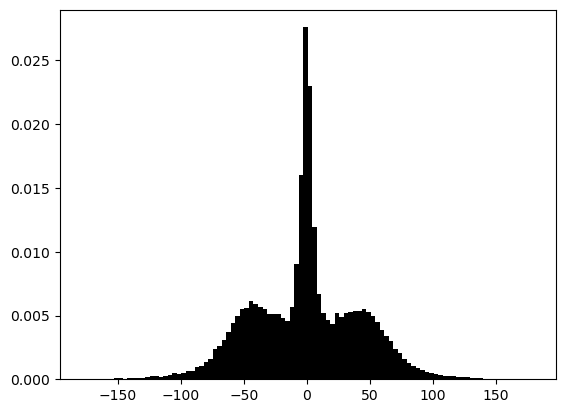

In [395]:
fig, ax = plt.subplots()
ax.hist(dthetas.ravel(), bins=100, color="k", density=True, stacked=True);

In [370]:
gm = GaussianMixture(n_components=3)
gm.fit(dthetas[np.isfinite(dthetas)][:,np.newaxis])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fe83ff9f520>
Traceback (most recent call last):
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


GaussianMixture(n_components=3)

In [371]:
gm

GaussianMixture(n_components=3)

In [372]:
gm.means_

array([[-38.14736785],
       [ 39.09887056],
       [ -0.10969744]])

In [440]:
gm.covariances_

array([[[909.74272826]],

       [[874.62766759]],

       [[ 21.01253787]]])

In [376]:
np.sqrt(gm.covariances_)

array([[[30.16194172]],

       [[29.57410468]],

       [[ 4.58394348]]])

In [389]:
gm.covariances_[1,0]

array([874.62766759])

In [383]:
x = np.linspace(np.nanmin(dthetas), np.nanmax(dthetas), 1000)

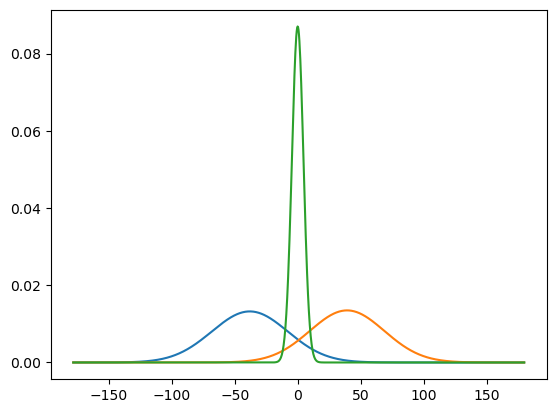

In [393]:
plt.plot(x, norm(loc=gm.means_[0], scale=np.sqrt(gm.covariances_[0,0])).pdf(x))
plt.plot(x, norm(loc=gm.means_[1], scale=np.sqrt(gm.covariances_[1,0])).pdf(x))
plt.plot(x, norm(loc=gm.means_[2], scale=np.sqrt(gm.covariances_[2,0])).pdf(x))

<BarContainer object of 500 artists>

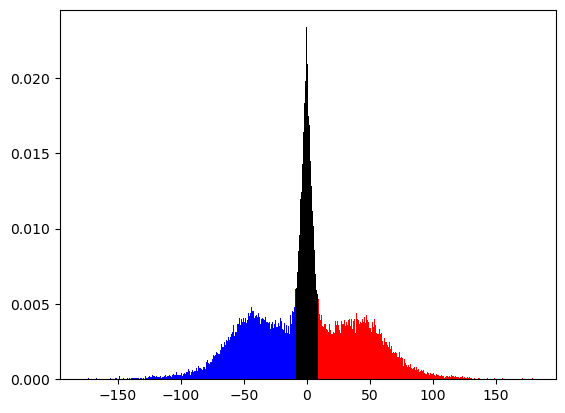

In [488]:
h, bins = np.histogram(dthetas[np.isfinite(dthetas)], bins=500)
h = h/h.sum()
predicted = gm.predict(bins[:,np.newaxis])
colors = [{p<0.5: 'blue', 0.5<=p<=1.5: 'red', p>1.5: 'black'}[True] for p in predicted]
fig, ax = plt.subplots()
ax.bar(bins[:-1], h, width=np.diff(bins), align="edge", color=colors)
#ax.plot(x, norm(loc=gm.means_[0], scale=np.sqrt(gm.covariances_[0,0])).pdf(x))
#ax.plot(x, norm(loc=gm.means_[1], scale=np.sqrt(gm.covariances_[1,0])).pdf(x))
#ax.plot(x, norm(loc=gm.means_[2], scale=np.sqrt(gm.covariances_[2,0])).pdf(x))

In [446]:
gm.predict(bins[:,np.newaxis])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Hidden Markov Model

In [407]:
from hmmlearn import hmm

## preparing the data

In [417]:
sequences = [seq[np.isfinite(seq)] for seq in dthetas]
lenghts = [len(seq) for seq in sequences]
long_seq = np.concatenate(sequences)
long_seq.shape

(48693,)

## Preparing the Model

In [561]:
model = hmm.GaussianHMM(n_components=3, covariance_type="diag", init_params="t", params="t")

model.startprob_ = p_bouts
model.transmat_ = T_bouts
model.means_ = np.array([[0], [-40], [+40]])
model.covars_ = np.array([
    [21],
    [900],
    [900]
])

In [552]:
model.fit(long_seq[:,np.newaxis], lenghts)

Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


GaussianHMM(init_params='t', n_components=3, params='t')

In [553]:
dths, bs = model.sample(10000)

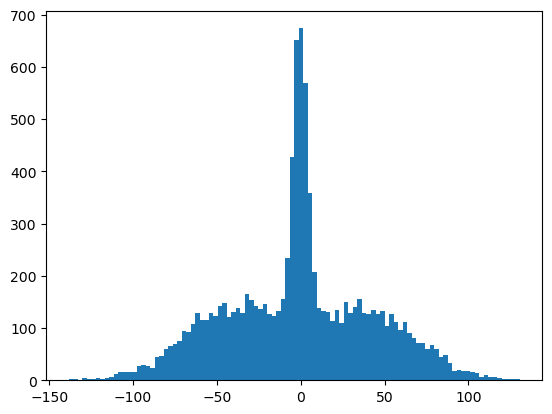

In [554]:
plt.hist(dths.ravel(), bins=100);

In [555]:
bs

array([0, 1, 1, ..., 2, 0, 2])

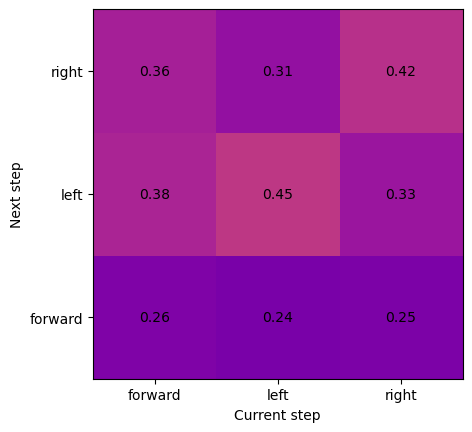

In [556]:
fig, ax = plt.subplots()
plot_transition_matrix(ax, bout_transition([bs]))

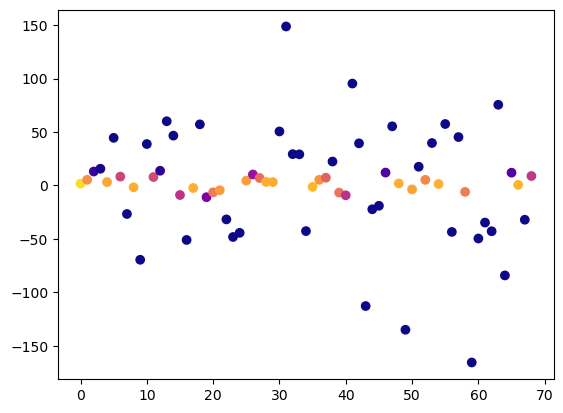

In [557]:
plt.scatter(
    np.arange(len(sequences[0])), 
    sequences[0], 
    c=model.predict_proba(sequences[0][:,np.newaxis])[:,0],
    vmin=0,
    vmax=1,
    cmap="plasma"
)

In [562]:
model.get_stationary_distribution()

array([0.50371241, 0.25085664, 0.24543095])

In [292]:
model.fit(dtheta[:,np.newaxis])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0a176f9750>
Traceback (most recent call last):
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Model is not converging.  Current: -406280.3054911075 is not greater than -185131.52686903047. Delta is -221

GaussianHMM(means_prior=array([0, 0, 0]), n_components=3)

In [293]:
model.monitor_.converged

True

In [294]:
model.means_

array([[-0.03706996, -0.03706996, -0.03706996],
       [-6.12474967, -6.12474967, -6.12474967],
       [ 5.9324199 ,  5.9324199 ,  5.9324199 ]])

In [295]:
np.sqrt(model.covars_)

array([[[ 6.74745243,  0.        ,  0.        ],
        [ 0.        ,  6.74745243,  0.        ],
        [ 0.        ,  0.        ,  6.74745243]],

       [[17.54476124,  0.        ,  0.        ],
        [ 0.        , 17.54476124,  0.        ],
        [ 0.        ,  0.        , 17.54476124]],

       [[17.91017874,  0.        ,  0.        ],
        [ 0.        , 17.91017874,  0.        ],
        [ 0.        ,  0.        , 17.91017874]]])

In [290]:
model.transmat_

array([[0.75073428, 0.14938519, 0.09988053],
       [0.48354274, 0.50327656, 0.0131807 ],
       [0.57014275, 0.00146452, 0.42839273]])

In [271]:
pturns = np.array([
    1-model.transmat_[0,0],
    2*model.transmat_[0,1],
    2*model.transmat_[0,2],
    2*model.transmat_[1,0]-1,
    2*model.transmat_[2,0]-1,
])
pturns, pturns.mean(), pturns.std()

(array([ 0.99996144,  1.39429156,  0.60563131, -0.84513437, -0.09283977]),
 0.41238203429258935,
 0.7979144981124228)

In [272]:
Z2 = model.predict(dtheta[:,np.newaxis])

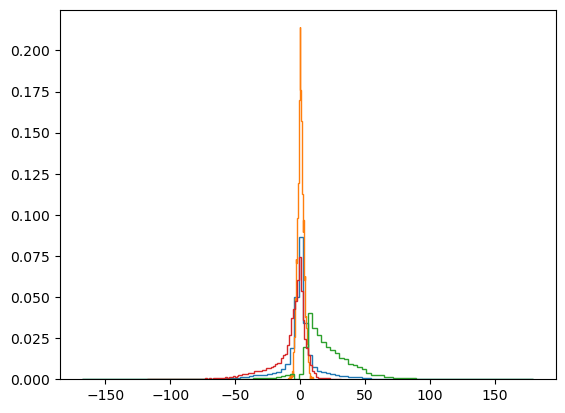

In [273]:
plt.hist(dtheta, bins=100, histtype="step", density=True);
plt.hist(dtheta[np.where(Z2==0)[0]], bins=100, histtype="step", density=True);
plt.hist(dtheta[np.where(Z2==1)[0]], bins=100, histtype="step", density=True);
plt.hist(dtheta[np.where(Z2==2)[0]], bins=100, histtype="step", density=True);

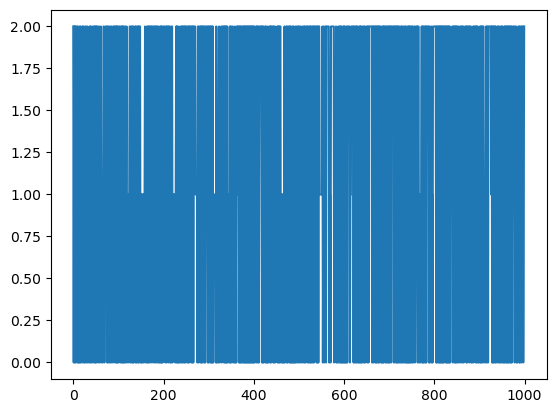

In [274]:
plt.plot(Z2[1000:2000])

In [275]:
np.unique(Z2, return_counts=True)

(array([0, 1, 2]), array([11851,  5451, 14701]))

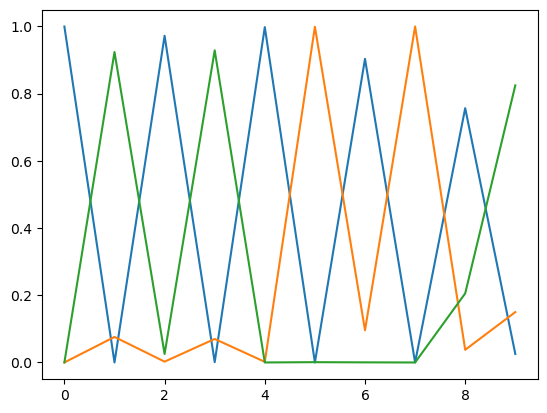

In [276]:
plt.plot(model.predict_proba(dtheta[:,np.newaxis])[:10,:])

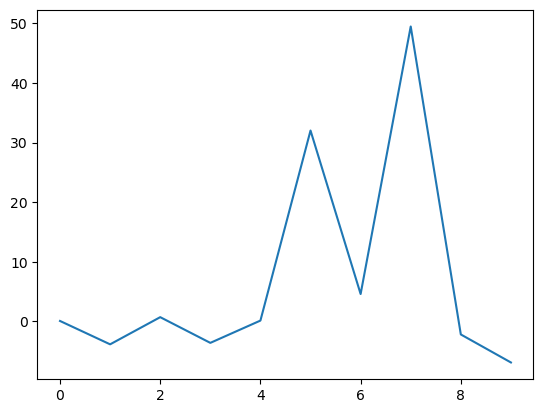

In [277]:
plt.plot(dtheta[:10])